In [67]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import boxcox

#import DL libs
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import regularizers 
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.layers import LSTM, GRU

plt.style.use('fivethirtyeight')


plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

%matplotlib inline

In [15]:
# util function
def plot_distributions(X):
    """
    plots distribution of numerical data from dataframe
    """
    X = pd.melt(X)
    g = sns.FacetGrid(X, col="variable",  col_wrap=3, sharex=False, sharey=False)
    g = g.map(sns.distplot, "value")
    
def plot_missing_values(X):
    """
    plots missing values per column of  dataframe in a bar chart 
    """
    missing = X.isnull().sum()
    missing = missing[missing>0]
    missing.sort_values(inplace=True)
    missing.plot.bar()
    
def spearman(frame, features=[], target='y'):
    """
    plots spearman correlation of each features with target
    """
    spr = pd.DataFrame()
    print(features)
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame[target], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
    
def plot_corr_heatmap(X, title="Corr Heatmap"):
    X_corr = X.corr()
    plt.figure(figsize=(12,7))
    # Add title
    plt.title(title)
    mask = np.zeros_like(X_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(mask=mask, data=X_corr, annot=True, cmap=cmap)
    
def pairplot_with_target(X, features, target):
    def pairplot(x, y, **kwargs):
        ax = plt.gca()
        ts = pd.DataFrame({'time': x, 'val': y})
        ts = ts.groupby('time').mean()
        ts.plot(ax=ax)
        plt.xticks(rotation=90)
    f = pd.melt(X, id_vars=[target], value_vars=features)
    g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False, size=5)
    g = g.map(pairplot, "value", target)

## PART 1

### 1) 
We are using bitcoin cash prices as the one of features

In [4]:
#read datasets
btc_price = pd.read_csv('../data/BTCPrice.csv', index_col=['Date'])
btc_price.columns = ['PRICE']

btc_trd_vol = pd.read_csv('../data/BTCTradeVolume.csv', index_col=['Date'])
btc_trd_vol.columns = [ 'TRD_VOLUME']

btc_miner_fees =  pd.read_csv('../data/BTCtransaction-fees.csv', index_col=['Date'])
btc_miner_fees.columns = ['MINERS_FEE']


btc_transaction_vol = pd.read_csv('../data/BTCTransactionVolume.csv', index_col=['Date'])
btc_transaction_vol.columns = ['TRAN_VOL']

btc_price_vol = pd.read_csv('../data/BTCprice-volatility.csv', index_col=['Date'])
btc_price_vol.columns = ['PRICE_VOL']

btc_miner_revenue =  pd.read_csv('../data/BTCminer-revenue.csv', index_col=['Date'])
btc_miner_revenue.columns = ['MINERS_REVENUE']

btc_difficulty = pd.read_csv('../data/BTCDifficulty.csv', index_col=['Date'])
btc_difficulty.columns = ['DIFFICULTY']

btc_transaction_per_block = pd.read_csv('../data/BTCTransactionPerBlock.csv', index_col=['Date'])
btc_transaction_per_block.columns = ['TRAN_BLOCK']

btc_hash_rate = pd.read_csv('../data/BTChash-rate.csv', index_col=['Date'])
btc_hash_rate.columns = ['HASH_RATE'] 

btc_market_cap = pd.read_csv('../data/BTCmarket-cap.csv', index_col=['Date'])
btc_market_cap.columns = ['MARKET_CAP'] 

bch_price =  pd.read_csv('../data/BCHprice.csv', index_col=['Date'])
bch_price.columns = ['BCH_PRICE']

btc_money_supply =  pd.read_csv('../data/BTCmoney-supply.csv', index_col=['Date'])
btc_money_supply.columns = ['MONEY_SUPPLY']

btc_data = pd.concat([btc_price, btc_trd_vol, btc_miner_fees, btc_transaction_vol, btc_price_vol,
                     btc_miner_revenue, btc_difficulty, btc_transaction_per_block, btc_hash_rate,
                     btc_money_supply, bch_price, btc_market_cap], axis=1, sort=True)
btc_data.index= pd.to_datetime(btc_data.index, format='%Y-%m-%d')
btc_data = btc_data.loc[(btc_data.index >= '2010-01-01') & (btc_data.index <= '2019-06-30')]

### 2)  Plot a time series of BTC prices

Text(0.5, 0, 'date')

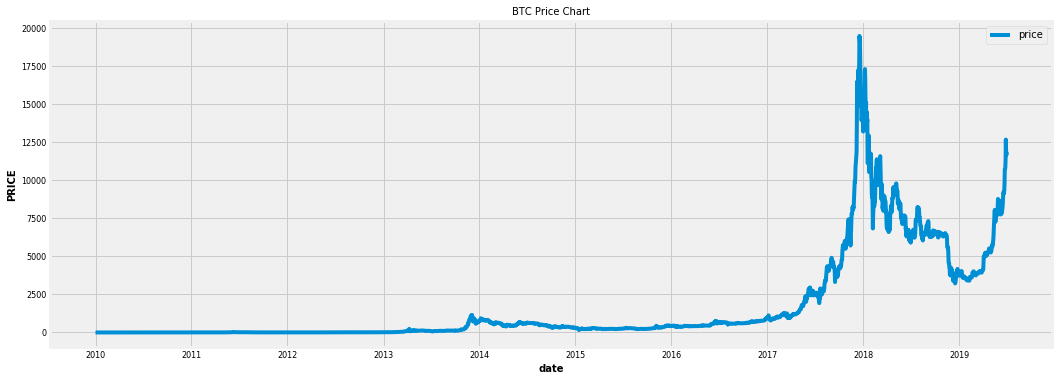

In [5]:
plt.figure(figsize=(16,6))
plt.title('BTC Price Chart')
sns.lineplot(btc_data.index, btc_data['PRICE'], label='price')
plt.xlabel('date')

### 3) Normalize each of the data fields, and plot them on the same plot with time on the x-axis and the normalized values on the y-axis

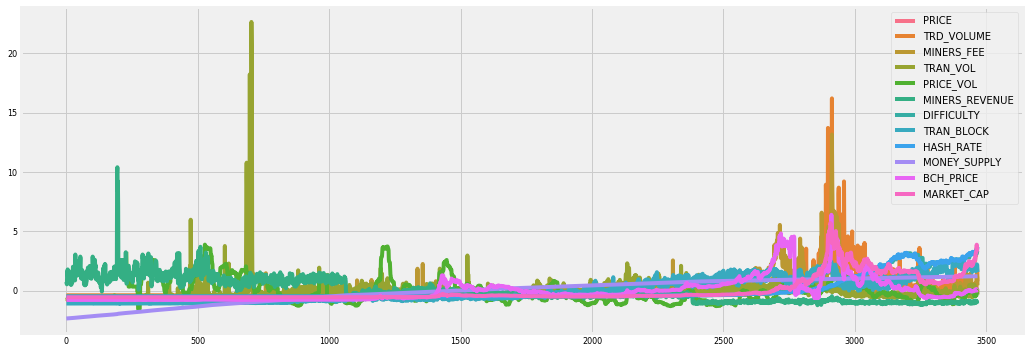

In [10]:
normalizer = StandardScaler()
base_features = btc_data.columns
btc_scaled = pd.DataFrame(normalizer.fit_transform(btc_data), columns=base_features)
plt.figure(figsize=(16,6))
sns.lineplot(data=btc_scaled, dashes=False)

### 4) Calculate a correlation matrix and identify any correlation in the features

#### EDA

,PRICE,TRD_VOLUME,MINERS_FEE,TRAN_VOL,PRICE_VOL,MINERS_REVENUE,DIFFICULTY,TRAN_BLOCK,HASH_RATE,MONEY_SUPPLY,BCH_PRICE,MARKET_CAP
PRICE,1.000000,0.806291,0.540697,-0.026031,0.035869,-0.477165,0.716016,0.625300,0.728248,0.550526,0.561856,0.999303
TRD_VOLUME,0.806291,1.000000,0.595977,0.023089,0.107160,-0.324247,0.412021,0.454935,0.419593,0.380109,0.492194,0.796789
MINERS_FEE,0.540697,0.595977,1.000000,0.119894,0.021230,-0.343062,0.098681,0.542060,0.105625,0.392018,0.722796,0.527457
TRAN_VOL,-0.026031,0.023089,0.119894,1.000000,-0.023320,-0.117201,-0.073879,0.122803,-0.074577,0.160137,0.085591,-0.028061
PRICE_VOL,0.035869,0.107160,0.021230,-0.023320,1.000000,0.427590,-0.099858,-0.324073,-0.098324,-0.440019,-0.042963,0.031498
MINERS_REVENUE,-0.477165,-0.324247,-0.343062,-0.117201,0.427590,1.000000,-0.456103,-0.749181,-0.457450,-0.875355,-0.525410,-0.475229
DIFFICULTY,0.716016,0.412021,0.098681,-0.073879,-0.099858,-0.456103,1.000000,0.621620,0.997975,0.524676,0.180113,0.733229
TRAN_BLOCK,0.625300,0.454935,0.542060,0.122803,-0.324073,-0.749181,0.621620,1.000000,0.621020,0.846631,0.576521,0.628854
HASH_RATE,0.728248,0.419593,0.105625,-0.074577,-0.098324,-0.457450,0.997975,0.621020,1.000000,0.527485,0.190424,0.745503
MONEY_SUPPLY,0.550526,0.380109,0.392018,0.160137,-0.440019,-0.875355,0.524676,0.846631,0.527485,1.000000,0.575668,0.549164


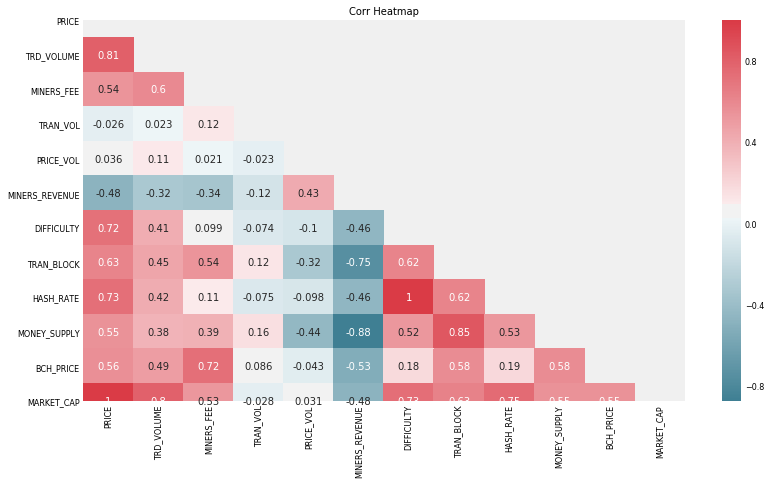

In [17]:
plot_corr_heatmap(btc_data)
btc_scaled.corr()

#### highly correlated

1) Money supply and transections per block 

2) BCH price and transactions per block 

4) hashrate and difficulty are almost perfectly correlated(we should drop one of thesse)

5) miners fee and bch price

6) transections per block and bch price

### Negatively corr

1) Miners revenue and transections per block 

2) Miners revenue and money supply(number of bitcoins)

We should drop difficulty as it is highly correlated with hashrate.

 
#### Correlation with price

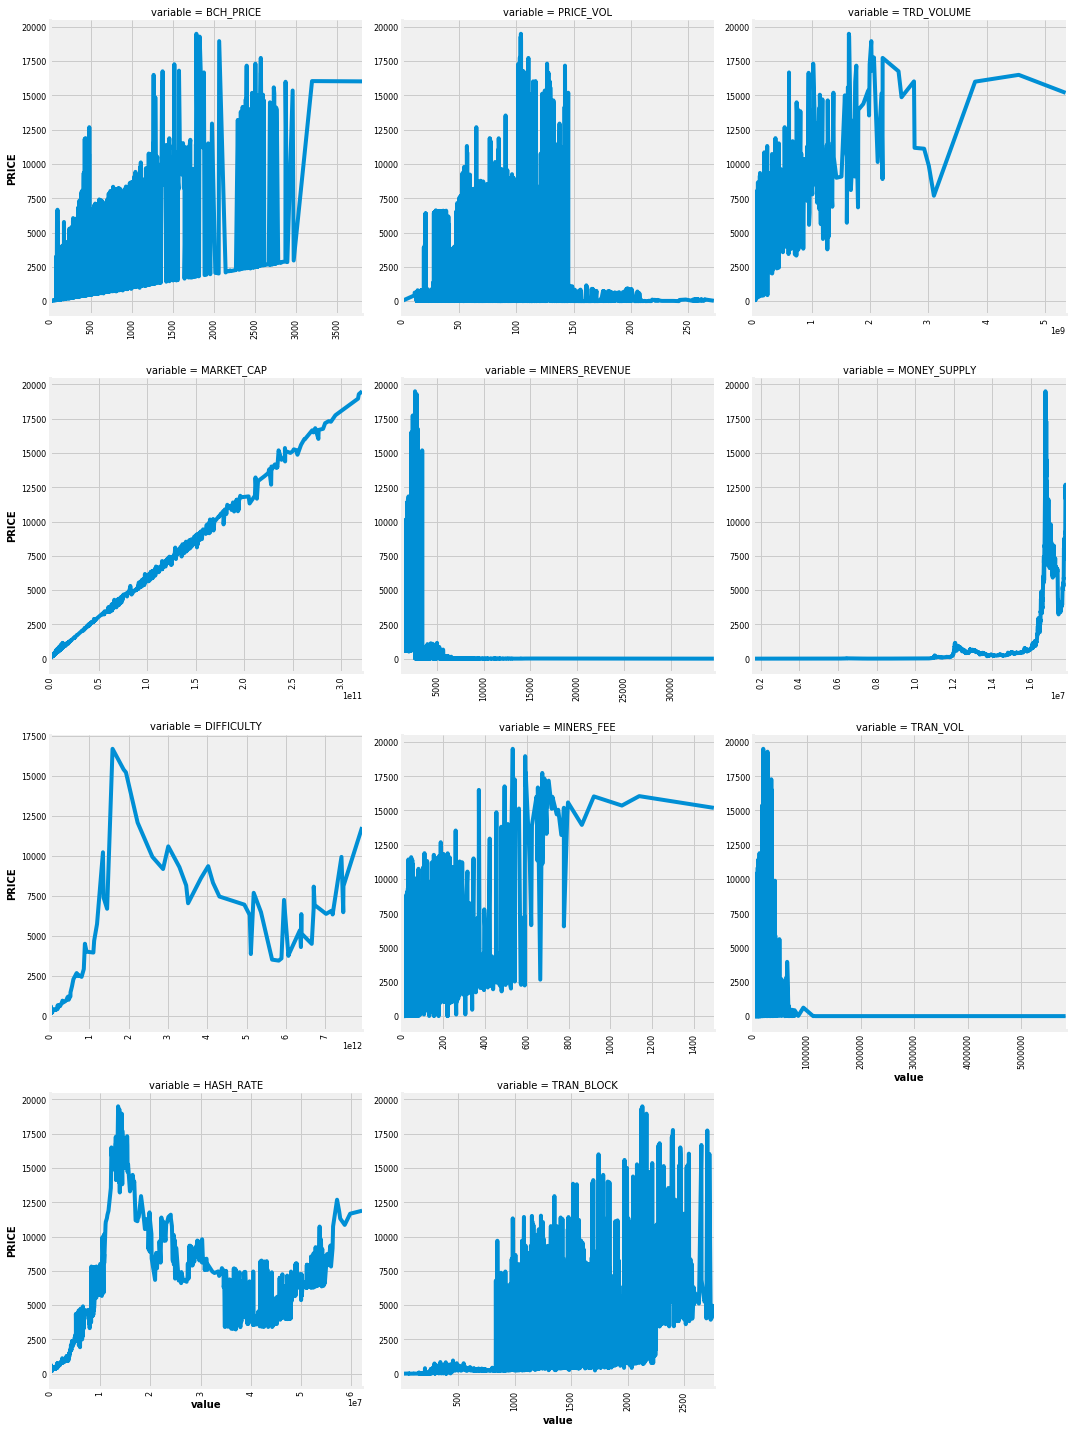

In [18]:
pairplot_with_target(btc_data, list(set(base_features) - set(['PRICE'])), 'PRICE')

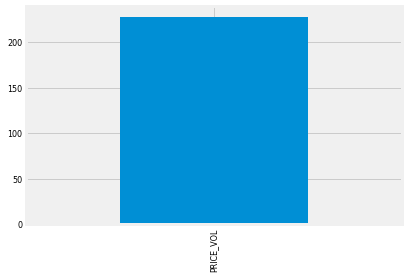

In [20]:
plot_missing_values(btc_data)

### 5)

We can see some linear relationship of target variable with features

### Observations

1) We have missing values for price volatility

2) Std dev of most of the columns is pretty high since 2010

3) We should reduce highly correlated features (this can be done using greedy algorithms or relying on L1 regularization of NNs)

4) Standardised features are not stationary which is evident from high shocks(non constant volatility) in the time series plot.
5) Difficulty and hash rate perfectly correlated, dropping one of those

6) 0 price does not make sense in the beginning of 2010. Its probably due to the lack of trading on exchanges at that time. It would be best to drop rows with 0 price or 0 trade volume. Since prices with 0 trading volume are also not reliable. Removing 0 price value also takes care of the missing value in the price vol column.

In [19]:
btc_data = btc_data.drop(['DIFFICULTY'], axis=1)
btc_data = btc_data.drop(btc_data[btc_data['PRICE']==0].index)

In [21]:
btc_data.describe()

,PRICE,TRD_VOLUME,MINERS_FEE,TRAN_VOL,PRICE_VOL,MINERS_REVENUE,TRAN_BLOCK,HASH_RATE,MONEY_SUPPLY,BCH_PRICE,MARKET_CAP
count,3468.000000,3.468000e+03,3468.000000,3.468000e+03,3240.000000,3468.000000,3468.000000,3.468000e+03,3.468000e+03,3468.000000,3.468000e+03
mean,1666.933055,1.206564e+08,57.571464,1.909034e+05,76.235959,4720.424693,825.328881,7.108041e+06,1.219943e+07,408.070802,2.782057e+10
std,3026.552150,3.229233e+08,109.320303,2.489385e+05,50.449536,2872.084456,771.898739,1.486635e+07,4.547524e+06,531.601825,5.145766e+10
min,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,1242.089114,1.000000,6.725089e-06,1.624700e+06,0.000000,0.000000e+00
25%,10.257500,3.715029e+05,11.058409,9.379575e+04,39.107889,2217.351151,136.000000,1.258546e+01,9.019988e+06,9.817500,8.087740e+07
50%,326.110000,5.416727e+06,22.339400,1.617277e+05,64.459420,3921.970160,497.000000,2.506518e+05,1.332991e+07,251.140000,4.467168e+09
75%,1028.995350,6.157338e+07,48.746183,2.451573e+05,99.656925,6907.039415,1489.670588,3.129050e+06,1.616010e+07,585.322500,1.638758e+10
max,19498.683333,5.352016e+09,1495.748916,5.825066e+06,272.447767,34600.000000,2762.540984,6.219192e+07,1.778861e+07,3810.470000,3.214197e+11


Now all columns have same length with no nan values

### Part 2

In [25]:
#feature engineering

#features using technical analysis

#moving average
btc_data['ma7'] = btc_data['PRICE'].rolling(7).mean()

#rolling price vol
btc_data['20sd'] = btc_data['PRICE'].rolling(20).std()
#moving average
btc_data['ma21'] = btc_data['PRICE'].rolling(window=21).mean()
#exponential moving average
btc_data['12ema'] = pd.DataFrame.ewm(btc_data['PRICE'], span=12).mean()

In [26]:
## splitting into train, valid and test

target = 'PRICE'
base_features = btc_data.columns

train_mask = (btc_data.index >= '2010-01-01') & (btc_data.index <= '2018-06-30')
valid_mask = (btc_data.index >= '2018-07-01') & (btc_data.index <= '2018-12-31')
test_mask = (btc_data.index >= '2019-01-01') & (btc_data.index <= '2019-06-30')

X_train =  btc_data.loc[train_mask][base_features]
y_train =  pd.DataFrame(btc_data.loc[train_mask][target])

X_valid =  btc_data.loc[valid_mask][base_features]
y_valid = pd.DataFrame(btc_data.loc[valid_mask][target])

X_test =  btc_data.loc[test_mask][base_features]
y_test =  pd.DataFrame(btc_data.loc[test_mask][target])

In [32]:
#normalization
constant_imputer = SimpleImputer(strategy='constant')

#normalizer
normalizer = StandardScaler()
y_normalizer = StandardScaler()

def preprocessing_pipeline(X, train=False):
    ind = X.index
    # Here we only scale the train dataset for fitting normalizer to prevent data leakage
    if  train:
        X = pd.DataFrame(constant_imputer.fit_transform(X), columns=base_features)
        X = pd.DataFrame(normalizer.fit_transform(X), columns=base_features)
    else:
        X = pd.DataFrame(constant_imputer.transform(X), columns=base_features)
        
        X = pd.DataFrame(normalizer.transform(X), columns=base_features)
    X.index = ind
    return X
        
def y_preprocessing_pipeline(y, train=False):
    ind = y.index
    if  train:
        y= pd.DataFrame(constant_imputer.fit_transform(y), columns=[target])

        y = pd.DataFrame(y_normalizer.fit_transform(y), columns=[target])
    else:
        y= pd.DataFrame(constant_imputer.transform(y), columns=[target])
        y = pd.DataFrame(y_normalizer.transform(y), columns=[target])
    y.index = ind
    return y

In [33]:
X_train_scaled = preprocessing_pipeline(X_train, train=True)
X_valid_scaled = preprocessing_pipeline(X_valid, train=False)
X_test_scaled = preprocessing_pipeline(X_test, train=False)

y_train_scaled = y_preprocessing_pipeline(y_train, train=True)
y_valid_scaled = y_preprocessing_pipeline(y_valid, train=False)
y_test_scaled = y_preprocessing_pipeline(y_test, train=False)

In [35]:
#### data processing Utils
def create_lagged_features(X,features, lag=3, dropna=False):
    """
    This function creates the lagged feature dataframe specifically useful for time series modelling
    """
    c_X = X
    lagged_dfs = [ c_X.shift(i).add_suffix('_' + str(i)) for i in range(lag)]
    lagged_dfs = pd.concat(lagged_dfs, axis=1)
    if dropna:
        lagged_dfs = lagged_dfs.dropna()
    return lagged_dfs

def create_leading_targets(X, lead=3, dropna=False):
    """
    This function creates leading targets specifically useful for predicting over multiple periods
    """
    leading_df = [ X.shift(-i).add_suffix('_' + str(i)) for i in range(1, lead+1)]
    leading_df =pd.concat(leading_df, axis=1)
    if dropna:
        leading_df = leading_df.dropna()
    return leading_df

In [48]:
X_train_lagged = create_lagged_features(X_train_scaled, base_features,lag=lag)[lag:-7]
y_train_leading = create_leading_targets(pd.DataFrame(y_train_scaled), lead=7)[lag:-7]

X_valid_lagged = create_lagged_features(X_valid_scaled, base_features,lag=lag)[lag:-7]
y_valid_leading = create_leading_targets(pd.DataFrame(y_valid_scaled), lead=7)[lag:-7]


X_test_lagged = create_lagged_features(X_test_scaled, base_features, lag=lag)[lag:-7]
y_test_leading = create_leading_targets(pd.DataFrame(y_test_scaled), lead=7)[lag:-7]

X_train_lagged.head()

,PRICE_0,TRD_VOLUME_0,MINERS_FEE_0,TRAN_VOL_0,PRICE_VOL_0,MINERS_REVENUE_0,TRAN_BLOCK_0,HASH_RATE_0,MONEY_SUPPLY_0,BCH_PRICE_0,...,MINERS_REVENUE_27,TRAN_BLOCK_27,HASH_RATE_27,MONEY_SUPPLY_27,BCH_PRICE_27,MARKET_CAP_27,ma7_27,20sd_27,ma21_27,12ema_27
2010-01-29,-0.428935,-0.300676,-0.514474,-0.751902,-1.330213,1.329581,-1.004785,-0.383153,-2.206233,-0.742033,...,0.541164,-1.004785,-0.383153,-2.254959,-0.742033,-0.41665,-0.428473,-0.33251,-0.427393,-0.429189
2010-01-30,-0.428935,-0.300676,-0.514474,-0.750945,-1.330213,1.679988,-1.004785,-0.383153,-2.204001,-0.742033,...,0.436041,-1.004785,-0.383153,-2.253531,-0.742033,-0.41665,-0.428473,-0.33251,-0.427393,-0.429189
2010-01-31,-0.428935,-0.300676,-0.514474,-0.747694,-1.330213,1.907753,-1.004785,-0.383153,-2.201621,-0.742033,...,1.487264,-1.004785,-0.383153,-2.251424,-0.742033,-0.41665,-0.428473,-0.33251,-0.427393,-0.429189
2010-02-01,-0.428935,-0.300676,-0.514474,-0.743678,-1.330213,1.119336,-1.004785,-0.383153,-2.199752,-0.742033,...,1.399662,-1.004785,-0.383153,-2.249373,-0.742033,-0.41665,-0.428473,-0.33251,-0.427393,-0.429189
2010-02-02,-0.428935,-0.300676,-0.514474,-0.754005,-1.330213,1.452223,-1.004785,-0.383153,-2.197667,-0.742033,...,1.697508,-1.004785,-0.383153,-2.247129,-0.742033,-0.41665,-0.428473,-0.33251,-0.427393,-0.429189


In [49]:
y_train_leading.tail()

,PRICE_1,PRICE_2,PRICE_3,PRICE_4,PRICE_5,PRICE_6,PRICE_7
2018-06-19,2.006721,1.998665,2.005601,1.860507,1.791465,1.753650,1.816716
2018-06-20,1.998665,2.005601,1.860507,1.791465,1.753650,1.816716,1.819300
2018-06-21,2.005601,1.860507,1.791465,1.753650,1.816716,1.819300,1.778338
2018-06-22,1.860507,1.791465,1.753650,1.816716,1.819300,1.778338,1.779278
2018-06-23,1.791465,1.753650,1.816716,1.819300,1.778338,1.779278,1.707263


we will start trading after 28 days and also stop trading 7 days before to avoid handling NaN cases 

Lets verify wheather input features are based on 28 days look back period and targets on next periods.

On 2018-06-19, we are using the prices and features from past 28 days to predict next 7 days prices. PRICE_1 is next day price and price 0 is the current day price.

### Part 3)

avg benchmark score:  537.2840142097441
last val benchmark score:  309.1737000183317


Text(0.5, 0, 'date')

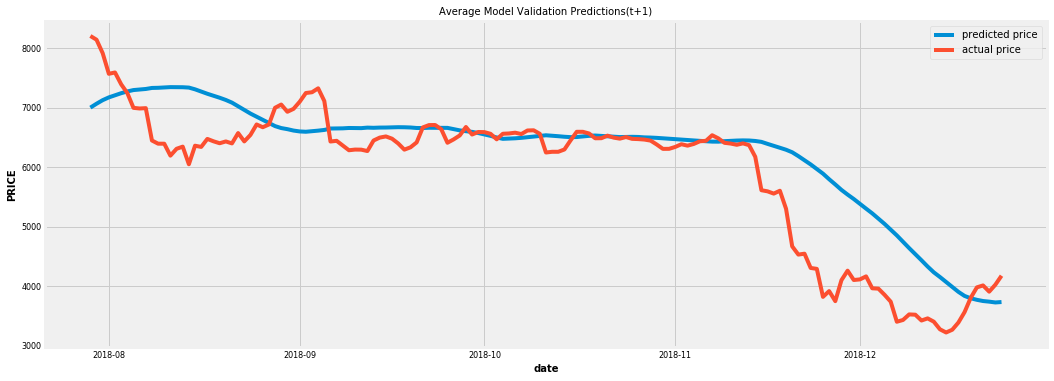

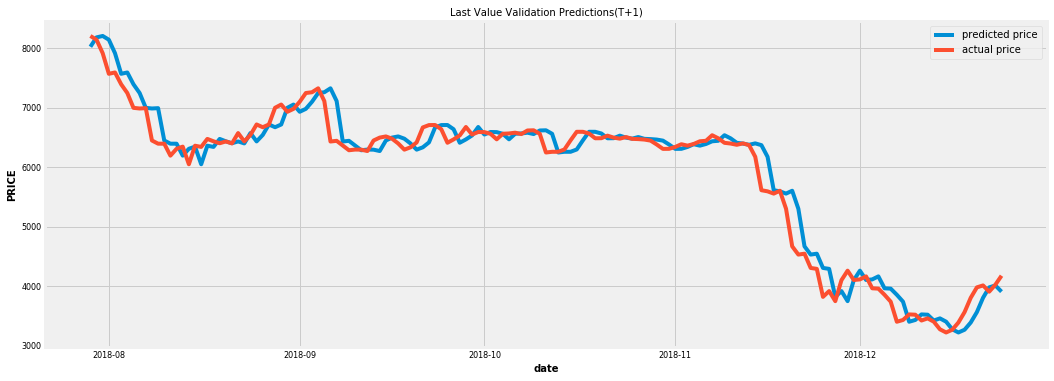

In [51]:
def get_avg_model_preds(data, target):
    y_preds = btc_data[target].rolling(28).mean().loc[y_valid_leading.index]
    return pd.concat([y_preds]*7, axis=1) 

def get_last_val_preds(data, target):
    y_preds = data[target].shift(1).loc[y_valid_leading.index]
    return pd.concat([y_preds]*7, axis=1) 

last_val_preds = get_last_val_preds(btc_data, target)
avg_model_preds = get_avg_model_preds(btc_data, target)
unnorm_y_valid = y_normalizer.inverse_transform(y_valid_leading)
print("avg benchmark score: ", mean_absolute_error(unnorm_y_valid, avg_model_preds))
print("last val benchmark score: ", mean_absolute_error(unnorm_y_valid, last_val_preds))


plt.figure(figsize=(16,6))
plt.title('Average Model Validation Predictions(t+1)')
sns.lineplot(y_valid_leading.index, avg_model_preds.iloc[:,0], label='predicted price')
sns.lineplot(y_valid_leading.index, unnorm_y_valid[:, 0], label='actual price')
plt.xlabel('date')


plt.figure(figsize=(16,6))
plt.title('Last Value Validation Predictions(T+1)')
sns.lineplot(y_valid_leading.index, last_val_preds.iloc[:,0], label='predicted price')
sns.lineplot(y_valid_leading.index, unnorm_y_valid[:, 0], label='actual price')

plt.xlabel('date')


### 
Now we will gather all code from above steps into single DLEngine class to make modelling simpler for further parts

In [63]:
class DLEngine:
    
    def __init__(self, data):
        self.raw_data = data
        
        self.X_train = None
        self.y_train = None
        self.X_valid = None
        self.y_valid = None
        self.X_test = None
        self.y_test = None
        self.performance_history=None
        
        self.preprocess_params = {"imputer": None,
                                  "normalizer": None,
                                  "boxcox_X_lam": {},
                                  "boxcox_y_lam": None}
        self.model = {"SNN": None,
                     "LSTM": None,
                     "GRU":None}
        self.__create_technical_analysis_features(data)
        
        
    def train_test_split(self, base_features, target='PRICE'):
        # lets split our data set before we do analysis on data set to make testing phase completely independent
        train_mask = (self.raw_data.index >= '2010-01-01') & (self.raw_data.index <= '2018-06-30')
        valid_mask = (self.raw_data.index >= '2018-07-01') & (self.raw_data.index <= '2018-12-31')
        test_mask = (self.raw_data.index >= '2019-01-01') & (self.raw_data.index <= '2019-06-30')

        self.X_train =  self.raw_data.loc[train_mask][base_features]
        self.y_train =  pd.DataFrame(self.raw_data.loc[train_mask][target])

        self.X_valid =  self.raw_data.loc[valid_mask][base_features]
        self.y_valid = pd.DataFrame(self.raw_data.loc[valid_mask][target])

        self.X_test =  self.raw_data.loc[test_mask][base_features]
        self.y_test =  pd.DataFrame(self.raw_data.loc[test_mask][target])
    
    # preprocessing:
    def __impute(self, X, train=False, strategy='constant'):
        ind = X.index
        col = X.columns
        if train:
            #using constant imputer for price volatility and standard scaler for normalization
            self.preprocess_params["imputer"] = SimpleImputer(strategy=strategy)
            X = pd.DataFrame(self.preprocess_params["imputer"].fit_transform(X), columns=col, index=ind)
        else:
            X = pd.DataFrame(self.preprocess_params["imputer"].transform(X), columns=col, index=ind)
        return X
    
    def __boxcox(self, X, is_X=True, train=False):
        '''is_X: True, boxcox for X; False, boxcox for y
        '''
        ind = X.index
        res = pd.DataFrame(index=ind)
        for col_name, series in X.iteritems():
            if train:
                bc = boxcox(series)
                res[col_name] = bc[0]
                if is_X:
                    self.preprocess_params["boxcox_X_lam"][col_name] = bc[1]
                else:
                    self.preprocess_params["boxcox_y_lam"] = bc[1]
            else:
                if is_X:
                    lam = self.preprocess_params["boxcox_X_lam"][col_name]
                else:
                    lam = self.preprocess_params["boxcox_y_lam"]
                res[col_name] = boxcox(series, lmbda=lam)
        return res
    
    def __boxcox_inv(self, y, lmbda):
        '''inverse boxcox transformation
        '''
        if lmbda == 0:
            return np.exp(y)
        else:
            return np.power(lmbda * y + 1, 1 / lmbda)
    
    def __normalize(self, X, train=False):
        ind = X.index
        col = X.columns
        if train:
            #normalizer
            self.preprocess_params["normalizer"] = StandardScaler()
            X = pd.DataFrame(self.preprocess_params["normalizer"].fit_transform(X), columns=col, index=ind)
        else:
            X = pd.DataFrame(self.preprocess_params["normalizer"].transform(X), columns=col, index=ind)
        return X
    
    def preprocessing(self, impute=True, boxcox=True, normalize=True, **kwargs):
        '''other parameters: strategy
        '''
        if impute:
            self.X_train = self.__impute(self.X_train, train=True, strategy=kwargs['strategy'])
            self.X_valid = self.__impute(self.X_valid, train=False, strategy=kwargs['strategy'])
            self.X_test = self.__impute(self.X_test, train=False, strategy=kwargs['strategy'])
        
        if boxcox:
            self.X_train = self.__boxcox(1 + self.X_train, is_X=True, train=True)
            self.y_train = self.__boxcox(1 + self.y_train, is_X=False, train=True)
            self.X_valid = self.__boxcox(1 + self.X_valid, is_X=True, train=False)
            self.y_valid = self.__boxcox(1 + self.y_valid, is_X=False, train=False)
            self.X_test = self.__boxcox(1 + self.X_test, is_X=True, train=False)
            self.y_test = self.__boxcox(1 + self.y_test, is_X=False, train=False)
        
        if normalize:
            self.X_train = self.__normalize(self.X_train, train=True)
            self.X_valid = self.__normalize(self.X_valid, train=False)
            self.X_test = self.__normalize(self.X_test, train=False)
    
    
    # feature engineering:
    
    def __create_technical_analysis_features(self, data):
        #features using technical analysis
        #moving average
        data['ma7'] = btc_data['PRICE'].rolling(7).mean()
        #rolling price vol
        data['20sd'] = btc_data['PRICE'].rolling(20).std()
        #moving average
        data['ma21'] = btc_data['PRICE'].rolling(window=21).mean()
        #exponential moving average
        data['12ema'] = pd.DataFrame.ewm(btc_data['PRICE'], span=12).mean()
        
    def __create_lagged_features(self, X, lag):
        """
        This function creates the lagged feature dataframe specifically useful for time series modelling
        """
        lagged_dfs = [X.shift(i).add_suffix('_' + str(i)) for i in range(lag)]
        return pd.concat(lagged_dfs, axis=1)

    def __create_leading_targets(self, X, lead):
        """
        This function creates leading targets specifically useful for predicting over multiple periods
        """
        leading_df = [X.shift(-i).add_suffix('_' + str(i)) for i in range(1, lead+1)]
        return pd.concat(leading_df, axis=1)
  

    def __create_3d_lagged_features(self, X, lag):
        x_array=[]
        for i in range(len(X)-lag):
            x_array.append(X.iloc[i:i+lag,:].as_matrix())
        x_array=np.asarray(x_array)
        return x_array
    
    def munge(self):
        self.X_train = self.__create_lagged_features(self.X_train, lag=28)[28:-7]
        self.y_train = self.__create_leading_targets(pd.DataFrame(self.y_train), lead=7)[28:-7]
        self.X_valid = self.__create_lagged_features(self.X_valid, lag=28)[28:-7]
        self.y_valid = self.__create_leading_targets(pd.DataFrame(self.y_valid), lead=7)[28:-7]
        self.X_test = self.__create_lagged_features(self.X_test, lag=28)[28:-7]
        self.y_test = self.__create_leading_targets(pd.DataFrame(self.y_test), lead=7)[28:-7]

    def munge_3d(self):
        self.X_train = self.__create_3d_lagged_features(self.X_train, lag=28)
        self.y_train = self.__create_leading_targets(pd.DataFrame(self.y_train), lead=7)[:-28]
        self.X_valid = self.__create_3d_lagged_features(self.X_valid, lag=28)
        self.y_valid = self.__create_leading_targets(pd.DataFrame(self.y_valid), lead=7)[:-28]
        self.X_test = self.__create_3d_lagged_features(self.X_test, lag=28)
        self.y_test = self.__create_leading_targets(pd.DataFrame(self.y_test), lead=7)[:-28]

    def build_snn(self, layers, neurons, regl=0.01, summary=True):
        '''simple neural network
        '''
        self.model["SNN"] = Sequential()
        input_dim = self.X_train.shape[1]
        output_dim = self.y_train.shape[1]
        if layers == 1:
            self.model["SNN"].add(Dense(output_dim, input_dim=input_dim, activation='linear', kernel_regularizer=regularizers.l2(regl)))
        else:
            self.model["SNN"].add(Dense(neurons, input_dim=input_dim, activation='relu', kernel_regularizer=regularizers.l2(regl)))
            for _ in range(layers-2):
                self.model["SNN"].add(Dense(neurons, activation='relu', kernel_regularizer=regularizers.l2(regl)))
            self.model["SNN"].add(Dense(output_dim, activation='linear', kernel_regularizer=regularizers.l2(regl)))
        self.model["SNN"].compile(loss='mae', optimizer='adam')
        if summary:
            print(self.model["SNN"].summary())

    def build_lstm(self, layers, neurons,dropout_rate, regl=0.01, summary=True):
        '''LSTM
        '''
        self.model["LSTM"] = Sequential()
        input_dim = self.X_train.shape[1]
        output_dim = self.y_train.shape[1]
        if layers == 1:
            self.model["LSTM"].add(LSTM(output_dim, recurrent_dropout=dropout_rate,input_shape=(self.X_train.shape[1],self.X_train.shape[2]),
                                        kernel_regularizer=regularizers.l2(regl)))
        else:
            if layers==2: self.model["LSTM"].add(LSTM(output_dim,recurrent_dropout=dropout_rate, input_shape=(self.X_train.shape[1],self.X_train.shape[2]), kernel_regularizer=regularizers.l2(regl)))
            else:             
                self.model["LSTM"].add(LSTM(neurons,recurrent_dropout=dropout_rate, return_sequences=True, input_shape=(self.X_train.shape[1],self.X_train.shape[2]),
                                        kernel_regularizer=regularizers.l2(regl)))
                for _ in range(layers-3):
                    self.model["LSTM"].add(LSTM(neurons, return_sequences=True, kernel_regularizer=regularizers.l2(regl)))
                self.model["LSTM"].add(LSTM(neurons, kernel_regularizer=regularizers.l2(regl)))
            self.model["LSTM"].add(Dense(output_dim, activation='linear', kernel_regularizer=regularizers.l2(regl)))
        self.model["LSTM"].compile(loss='mae', optimizer='adam')
        if summary:
            print(self.model["LSTM"].summary())

    def build_gru(self, layers, neurons,dropout_rate=0.5, regl=0.01, summary=True):
        '''GRU
        '''
        self.model["GRU"] = Sequential()
        input_dim = self.X_train.shape[1]
        output_dim = self.y_train.shape[1]
        if layers == 1:
            self.model["GRU"].add(GRU(output_dim,recurrent_dropout=dropout_rate, input_shape=(self.X_train.shape[1],self.X_train.shape[2]),
                                        kernel_regularizer=regularizers.l2(regl)))
        else:
            if layers==2: self.model["GRU"].add(GRU(output_dim,recurrent_dropout=dropout_rate, input_shape=(self.X_train.shape[1],self.X_train.shape[2]), kernel_regularizer=regularizers.l2(regl)))
            else:             
                self.model["GRU"].add(GRU(neurons,recurrent_dropout=dropout_rate, return_sequences=True, input_shape=(self.X_train.shape[1],self.X_train.shape[2]),
                                        kernel_regularizer=regularizers.l2(regl)))
                for _ in range(layers-3):
                    self.model["GRU"].add(GRU(neurons, return_sequences=True, kernel_regularizer=regularizers.l2(regl)))
                self.model["GRU"].add(GRU(neurons, kernel_regularizer=regularizers.l2(regl)))
            self.model["GRU"].add(Dense(output_dim, activation='linear', kernel_regularizer=regularizers.l2(regl)))
        self.model["GRU"].compile(loss='mae', optimizer='adam')
        if summary:
            print(self.model["GRU"].summary())
      
    def train(self, model, epochs=40):
        """model: SNN, LSTM, GRU, RNN
        """
        self.performance_history = self.model[model].fit(self.X_train, self.y_train, epochs=epochs,
                                                         validation_data=(self.X_valid, self.y_valid))
    # predict
    def predict(self, model, X):
        y_pred = self.model[model].predict(X)
        if self.preprocess_params["boxcox_y_lam"]:
            y_pred = self.__boxcox_inv(y_pred, self.preprocess_params["boxcox_y_lam"]) - 1
        return y_pred
    
    # evaluate:
    def score(self, model, X, y_true):
        y_pred = self.predict(model, X)
        return mean_absolute_error(y_true, y_pred), np.sqrt(mean_squared_error(y_true, y_pred))
    
    def result_evaluation(self, model):
        pyplot.plot(self.performance_history.history['loss'], label='train', color='brown')
        pyplot.plot(self.performance_history.history['val_loss'], label='valid', color='blue')
        pyplot.title(model+" training loss vs. validation loss")
        pyplot.legend()
        pyplot.show()
    
    def plot_predictions(self, model, X, y_true):
        y_pred = self.predict(model, X)
        plt.figure(figsize=(16,6))
        plt.title('Predictions(t+1)')
        sns.lineplot(self.y_valid.index, y_pred[:,0], label='predicted price t+1')
        sns.lineplot(self.y_valid.index, y_true.iloc[:, 0], label='actual price')
        plt.xlabel('date')


### Part3 Q2: Simple Neural Network


In [64]:
#simple neural network
np.random.seed(0)
engine = DLEngine(btc_data)
base_features = btc_data.columns
engine.train_test_split(base_features)
engine.preprocessing(strategy='constant')
engine.munge()
engine.build_snn(2, 50, regl=0.05, summary=True)
engine.train('SNN')
y_train_true = engine._DLEngine__boxcox_inv(engine.y_train, engine.preprocess_params["boxcox_y_lam"]) - 1
y_valid_true = engine._DLEngine__boxcox_inv(engine.y_valid, engine.preprocess_params["boxcox_y_lam"]) - 1
y_test_true = engine._DLEngine__boxcox_inv(engine.y_test, engine.preprocess_params["boxcox_y_lam"]) - 1

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 50)                21050     
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 357       
Total params: 21,407
Trainable params: 21,407
Non-trainable params: 0
_________________________________________________________________
None
Train on 3068 samples, validate on 149 samples
Epoch 1/40
3068/3068 [==============================] - 0s 161us/step - loss: 5.5400 - val_loss: 3.8263
Epoch 2/40
3068/3068 [==============================] - 0s 62us/step - loss: 2.5015 - val_loss: 4.0548
Epoch 3/40
3068/3068 [==============================] - 0s 59us/step - loss: 1.6788 - val_loss: 3.2901
Epoch 4/40
3068/3068 [==============================] - 0s 61us/step - loss: 1.3506 - val_loss: 2.7621
Epoch 5/40
3068/3068 [=========================

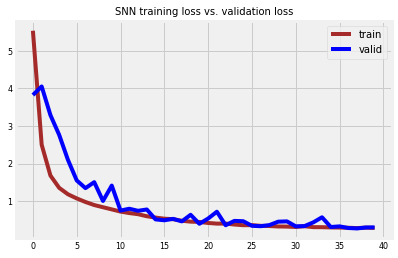

Training  error: MAE: 153.25569063275685 RMSE 568.7356126894732
validation error: MAE 580.8609962379339 RMSE 669.5286039871523
Testing error: MAE 947.0611091655057 RMSE 1181.944340650544


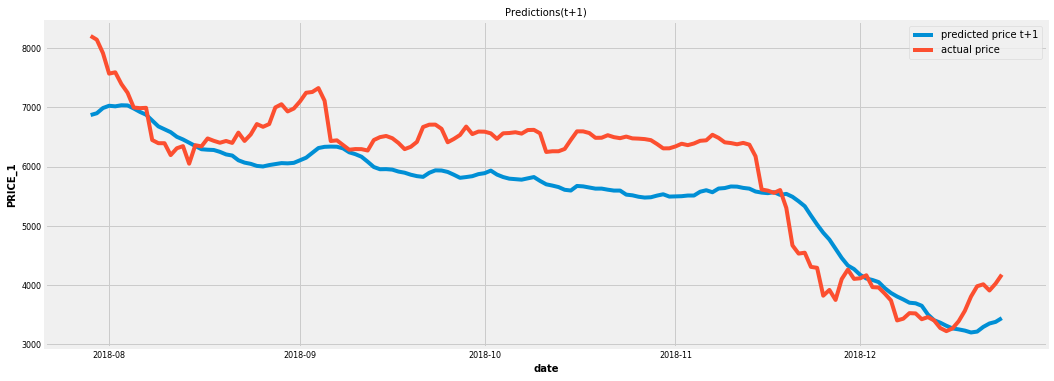

In [68]:
engine.result_evaluation('SNN')
print ("Training  error: MAE:",engine.score("SNN", engine.X_train, y_train_true)[0],
       "RMSE",engine.score("SNN", engine.X_train, y_train_true)[1])
print ("validation error: MAE",engine.score("SNN", engine.X_valid, y_valid_true)[0],      
       "RMSE",engine.score("SNN", engine.X_valid, y_valid_true)[1])
print ("Testing error: MAE",engine.score("SNN", engine.X_test, y_test_true)[0],      
       "RMSE",engine.score("SNN", engine.X_test, y_test_true)[1])

engine.plot_predictions("SNN", engine.X_valid, y_valid_true)

### Part3 Q3: LSTM

In [69]:
#LSTM
engine = DLEngine(btc_data)
base_features = btc_data.columns
engine.train_test_split(base_features)
engine.preprocessing(boxcox=True, strategy='constant')
engine.munge_3d()
engine.build_lstm(3, 32,dropout_rate=0.0, regl=0.0, summary=True)
engine.train('LSTM')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 28, 32)            6144      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 231       
Total params: 14,695
Trainable params: 14,695
Non-trainable params: 0
_________________________________________________________________
None
Train on 3075 samples, validate on 156 samples
Epoch 1/40
3075/3075 [==============================] - 7s 2ms/step - loss: 3.4888 - val_loss: 5.4031
Epoch 2/40
3075/3075 [==============================] - 5s 2ms/step - loss: 0.8852 - val_loss: 3.0490
Epoch 3/40
3075/3075 [==============================] - 4s 1ms/step - loss: 0.4376 - val_loss: 1.9117
Epoch 4/40
3075/3075 [

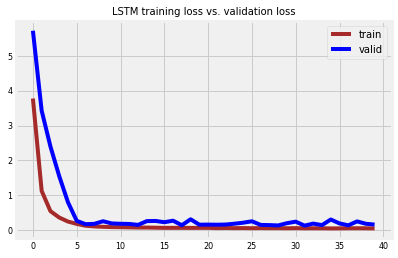

AttributeError: 'NoneType' object has no attribute 'predict'

In [81]:
y_train_true = engine._DLEngine__boxcox_inv(engine.y_train, engine.preprocess_params["boxcox_y_lam"]) - 1
y_valid_true = engine._DLEngine__boxcox_inv(engine.y_valid, engine.preprocess_params["boxcox_y_lam"]) - 1
y_test_true = engine._DLEngine__boxcox_inv(engine.y_test, engine.preprocess_params["boxcox_y_lam"]) - 1
engine.result_evaluation('LSTM')
print ("Training  error: MAE:",engine.score("LSTM", engine.X_train, y_train_true)[0],
       "RMSE:",engine.score("LSTM", engine.X_train, y_train_true)[1])
print ("validation error: MAE:",engine.score("LSTM", engine.X_valid, y_valid_true)[0],      
       "RMSE:",engine.score("LSTM", engine.X_valid, y_valid_true)[1])
print ("Testing error: MAE:",engine.score("LSTM", engine.X_test, y_test_true)[0],      
       "RMSE:",engine.score("LSTM", engine.X_test, y_test_true)[1])

engine.plot_predictions("LSTM", engine.X_valid, y_valid_true)

### Part3 Q4

In [71]:
#GRU
engine = DLEngine(btc_data)
base_features = btc_data.columns
engine.train_test_split(base_features)
engine.preprocessing(boxcox=True, strategy='constant')
engine.munge_3d()
engine.build_gru(2, 32,dropout_rate=0, regl=0.0, summary=True)
engine.train('GRU')
y_train_true = engine._DLEngine__boxcox_inv(engine.y_train, engine.preprocess_params["boxcox_y_lam"]) - 1
y_valid_true = engine._DLEngine__boxcox_inv(engine.y_valid, engine.preprocess_params["boxcox_y_lam"]) - 1
print ("Training  error:",engine.score("GRU", engine.X_train, y_train_true))
print ("validation error:",engine.score("GRU", engine.X_valid, y_valid_true))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 7)                 483       
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 56        
Total params: 539
Trainable params: 539
Non-trainable params: 0
_________________________________________________________________
None
Train on 3075 samples, validate on 156 samples
Epoch 1/40
3075/3075 [==============================] - 3s 1ms/step - loss: 5.1515 - val_loss: 9.9774
Epoch 2/40
3075/3075 [==============================] - 2s 693us/step - loss: 4.2247 - val_loss: 8.6074
Epoch 3/40
3075/3075 [==============================] - 2s 701us/step - loss: 3.1454 - val_loss: 7.4556
Epoch 4/40
3075/3075 [==============================] - 2s 688us/step - loss: 2.5040 - val_loss: 6.5369
Epoch 5/40
3075/3075 [==============================

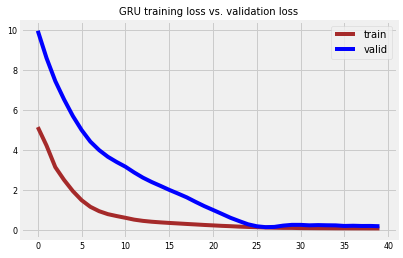

Training  error: MAE: 145.484669235173 RMSE: 710.9547068660208
validation error: MAE: 830.9024488034077 RMSE: 945.8124333312269
Testing error: MAE: 678.3980400943858 RMSE: 746.6988413955481


In [72]:
y_test_true = engine._DLEngine__boxcox_inv(engine.y_test, engine.preprocess_params["boxcox_y_lam"]) - 1
engine.result_evaluation('GRU')
print ("Training  error: MAE:",engine.score("GRU", engine.X_train, y_train_true)[0],
       "RMSE:",engine.score("GRU", engine.X_train, y_train_true)[1])
print ("validation error: MAE:",engine.score("GRU", engine.X_valid, y_valid_true)[0],      
       "RMSE:",engine.score("GRU", engine.X_valid, y_valid_true)[1])
print ("Testing error: MAE:",engine.score("GRU", engine.X_test, y_test_true)[0],      
       "RMSE:",engine.score("GRU", engine.X_test, y_test_true)[1])

### Part3 Q5
Build and train an RNN model with a GRU layer and recurrent dropout and print the train
and validation loss for each epoch

In [73]:
#GRU
engine = DLEngine(btc_data)
base_features = btc_data.columns
engine.train_test_split(base_features)
engine.preprocessing(boxcox=True, strategy='constant')
engine.munge_3d()
engine.build_gru(2, 32,dropout_rate=0.5, regl=0.0, summary=True)
engine.train('GRU')

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 7)                 483       
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 56        
Total params: 539
Trainable params: 539
Non-trainable params: 0
_________________________________________________________________
None
Train on 3075 samples, validate on 156 samples
Epoch 1/40
3075/3075 [==============================] - 4s 1ms/step - loss: 5.0771 - val_loss: 9.3289
Epoch 2/40
3075/3075 [==============================] - 2s 800us/step - loss: 4.4486 - val_loss: 8.3575
Epoch 3/40
3075/3075 [==============================] - 2s 754us/step - loss: 3.4950 - val_loss: 7.1771
Epoch 4/40
3075/3075 [==============================] - 3s 864us/step - loss: 2.5831 - val_loss: 6.1096
Epoch 5/40
3075/3075 [==============================

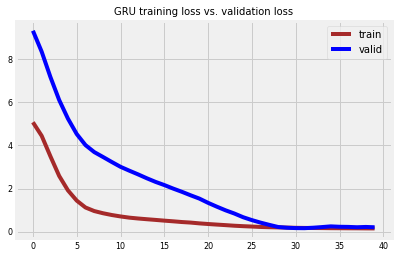

Training  error: MAE: 241.77866446712952 RMSE: 956.4906410185696
validation error: MAE: 838.6866343350392 RMSE: 983.2588245595463
Testing error: MAE: 1404.8423824420947 RMSE: 1511.701073195618


In [74]:
y_train_true = engine._DLEngine__boxcox_inv(engine.y_train, engine.preprocess_params["boxcox_y_lam"]) - 1
y_valid_true = engine._DLEngine__boxcox_inv(engine.y_valid, engine.preprocess_params["boxcox_y_lam"]) - 1
y_test_true = engine._DLEngine__boxcox_inv(engine.y_test, engine.preprocess_params["boxcox_y_lam"]) - 1
engine.result_evaluation('GRU')
print ("Training  error: MAE:",engine.score("GRU", engine.X_train, y_train_true)[0],
       "RMSE:",engine.score("GRU", engine.X_train, y_train_true)[1])
print ("validation error: MAE:",engine.score("GRU", engine.X_valid, y_valid_true)[0],      
       "RMSE:",engine.score("GRU", engine.X_valid, y_valid_true)[1])
print ("Testing error: MAE:",engine.score("GRU", engine.X_test, y_test_true)[0],      
       "RMSE:",engine.score("GRU", engine.X_test, y_test_true)[1])
engine.plot_predictions("GRU", engine.X_valid, y_valid_true)

### Part3 Q6
Add an additional GRU layer to (5) above with dropout and recurrent dropout and print
the train and validation loss

In [75]:
#GRU
engine = DLEngine(btc_data)
base_features = btc_data.columns
engine.train_test_split(base_features)
engine.preprocessing(boxcox=True, strategy='constant')
engine.munge_3d()
engine.build_gru(3, 32,dropout_rate=0.5, regl=0.0, summary=True)
engine.train('GRU')

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 28, 32)            4608      
_________________________________________________________________
gru_4 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_8 (Dense)              (None, 7)                 231       
Total params: 11,079
Trainable params: 11,079
Non-trainable params: 0
_________________________________________________________________
None
Train on 3075 samples, validate on 156 samples
Epoch 1/40
3075/3075 [==============================] - 7s 2ms/step - loss: 3.7732 - val_loss: 5.7146
Epoch 2/40
3075/3075 [==============================] - 4s 1ms/step - loss: 1.1271 - val_loss: 3.4241
Epoch 3/40
3075/3075 [==============================] - 4s 1ms/step - loss: 0.5474 - val_loss: 2.4000
Epoch 4/40
3075/3075 [

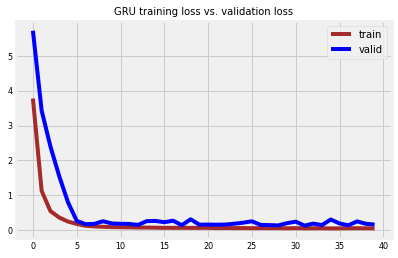

Training  error: MAE: 70.01443823054599 RMSE: 267.91825786088197
validation error: MAE: 594.3764768266756 RMSE: 720.296205575359
Testing error: MAE: 535.4584217649839 RMSE: 591.2847078593471


In [76]:
y_train_true = engine._DLEngine__boxcox_inv(engine.y_train, engine.preprocess_params["boxcox_y_lam"]) - 1
y_valid_true = engine._DLEngine__boxcox_inv(engine.y_valid, engine.preprocess_params["boxcox_y_lam"]) - 1
y_test_true = engine._DLEngine__boxcox_inv(engine.y_test, engine.preprocess_params["boxcox_y_lam"]) - 1
engine.result_evaluation('GRU')
print ("Training  error: MAE:",engine.score("GRU", engine.X_train, y_train_true)[0],
       "RMSE:",engine.score("GRU", engine.X_train, y_train_true)[1])
print ("validation error: MAE:",engine.score("GRU", engine.X_valid, y_valid_true)[0],      
       "RMSE:",engine.score("GRU", engine.X_valid, y_valid_true)[1])
print ("Testing error: MAE:",engine.score("GRU", engine.X_test, y_test_true)[0],      
       "RMSE:",engine.score("GRU", engine.X_test, y_test_true)[1])
engine.plot_predictions("GRU", engine.X_valid, y_valid_true)

### Part3 Q7


### 7). (bonus) 
### Build a classic time series model ARIMA, and VAR(Vector AutoRegression), calculate train and validation loss

In [109]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

#### In this part, we don't need cross-validation set to tune hyper-parameters, that's why we merge vaildation set and test set

In [123]:
X_train = X_train.dropna()
X_valid = X_valid.dropna()
X_test = X_test.dropna()

X_valid_ts = pd.concat([X_valid,X_test])
y_vaild_ts = pd.concat([y_valid,y_test])

X_valid_ts.shape



(365, 15)

### 7.1) ARIMA models:

**Step1: Check for Stationarity and Make the Time Series Stationary**

In [124]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

adfuller_test(X_train['PRICE'], name=X_train.columns[0])  

    Augmented Dickey-Fuller Test on "PRICE" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.9118
 No. Lags Chosen       = 27
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.3265. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


The PRICE time-series is **non-stationary**, we take first-order difference,and re-run ADF test on differenced series.

In [125]:
# 1st-order difference
X_train_price_diff1= X_train['PRICE'].diff().dropna()
adfuller_test(X_train_price_diff1, name='PRICE')

    Augmented Dickey-Fuller Test on "PRICE" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.7914
 No. Lags Chosen       = 28
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


Right now, the 'PRICE' time series is **stationary** 

**Step2: Using ARIMA model**

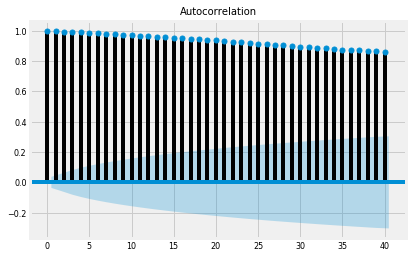

In [126]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(X_train['PRICE'].values.squeeze(), lags=40)
plt.show()

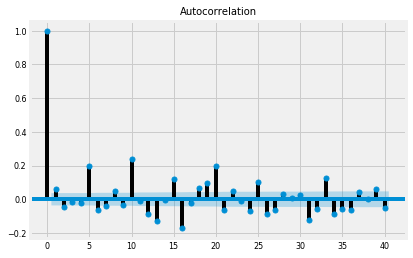

In [127]:
sm.graphics.tsa.plot_acf(X_train_price_diff1.values.squeeze(), lags=40)
plt.show()

#### Using ARIMA with dynamic regression, which is an auto_ARIMA
auto_arima() uses a stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model that has the least AIC.

In [128]:
import pmdarima as pm

model = pm.auto_arima(X_train['PRICE'].values, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # the difference order is 1
                      seasonal=False,   # No Seasonality
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Fit ARIMA: order=(1, 1, 1); AIC=38111.923, BIC=38135.776, Fit time=0.484 seconds
Fit ARIMA: order=(0, 1, 0); AIC=38140.971, BIC=38152.898, Fit time=0.004 seconds
Fit ARIMA: order=(1, 1, 0); AIC=38131.540, BIC=38149.430, Fit time=0.038 seconds
Fit ARIMA: order=(0, 1, 1); AIC=38130.316, BIC=38148.207, Fit time=0.025 seconds
Fit ARIMA: order=(2, 1, 1); AIC=38127.683, BIC=38157.501, Fit time=0.440 seconds
Fit ARIMA: order=(1, 1, 2); AIC=38113.295, BIC=38143.112, Fit time=0.560 seconds
Fit ARIMA: order=(2, 1, 2); AIC=38058.714, BIC=38094.495, Fit time=2.069 seconds
Fit ARIMA: order=(3, 1, 2); AIC=38034.650, BIC=38076.394, Fit time=4.287 seconds
Fit ARIMA: order=(3, 1, 1); AIC=38129.572, BIC=38165.353, Fit time=0.697 seconds
Fit ARIMA: order=(3, 1, 3); AIC=37989.008, BIC=38036.716, Fit time=2.308 seconds
Fit ARIMA: order=(4, 1, 4); AIC=37858.229, BIC=37917.864, Fit time=4.702 seconds
Fit ARIMA: order=(3, 1, 4); AIC=37985.753, BIC=38039.425, Fit time=3.569 seconds
Fit ARIMA: order=(5, 1, 4); 

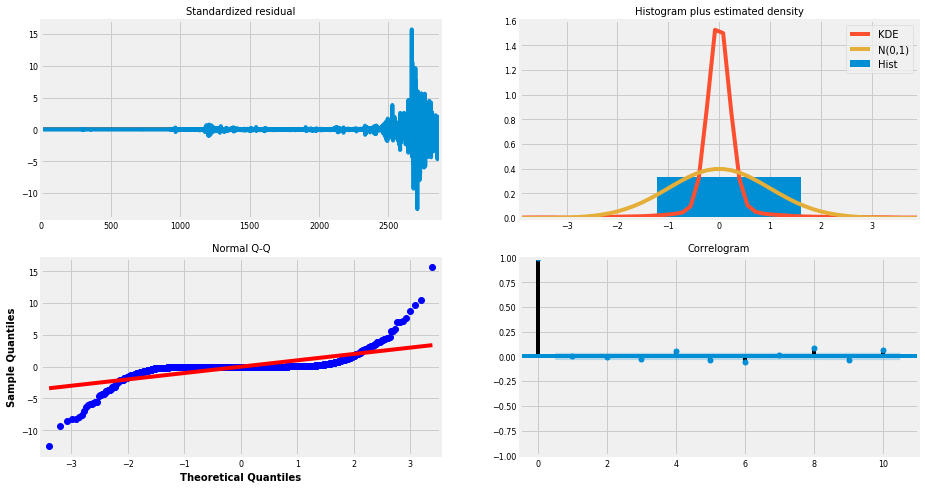

In [129]:
model.plot_diagnostics(figsize=(14,8))
plt.show()

**Plot interpretation:**

**Top left:** The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

**Top Right:** The density plot suggest normal distribution with mean zero.

**Bottom left:** All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

**Bottom Right:** The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. 

Overall, it seems to be a good fit. Let’s forecast.

Forecast Accuracy of Price using ARIMA(5,1,5): 
 MAE = 1589.4393
RMSE = 1882.1599


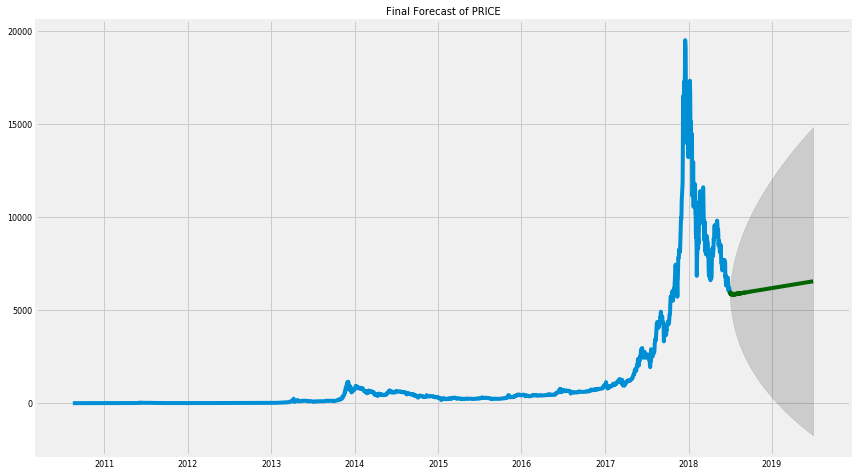

In [130]:
# Forecast
n_periods = X_valid_ts['PRICE'].shape[0]
df = X_train['PRICE']
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = X_valid_ts.index

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

def forecast_accuracy(forecast, actual):
    mae = np.mean(np.abs(forecast - actual))
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE# MAE
    return  mae, rmse

# compute MAE
mae ,rmse = forecast_accuracy(fc_series, X_valid_ts['PRICE']) 
print('Forecast Accuracy of Price using ARIMA(5,1,5): \n MAE =',round(mae,4))
print('RMSE =', round(rmse,4))

# Plot
plt.figure(figsize=(13,8))
plt.plot(df)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of PRICE")
plt.show()

### 7.2) VAR models:

**Step1: Testing Causation using Granger’s Causality Test**

In [131]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(X_train, variables = X_train.columns)

,PRICE_x,TRD_VOLUME_x,MINERS_FEE_x,TRAN_VOL_x,PRICE_VOL_x,MINERS_REVENUE_x,TRAN_BLOCK_x,HASH_RATE_x,MONEY_SUPPLY_x,BCH_PRICE_x,MARKET_CAP_x,ma7_x,20sd_x,ma21_x,12ema_x
PRICE_y,1.0000,0.0000,0.0000,0.6358,0.3773,0.2415,0.0017,0.0000,0.1640,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
TRD_VOLUME_y,0.0000,1.0000,0.0000,0.5168,0.2284,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
MINERS_FEE_y,0.0000,0.0000,1.0000,0.0000,0.3698,0.0001,0.0000,0.0000,0.0008,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
TRAN_VOL_y,0.7784,0.4388,0.3998,1.0000,0.0517,0.0681,0.0488,0.4415,0.0487,0.3552,0.7786,0.7357,0.6432,0.6704,0.7145
PRICE_VOL_y,0.4807,0.2773,0.0859,0.0170,1.0000,0.0428,0.3391,0.8769,0.0357,0.2089,0.4951,0.4342,0.1554,0.4726,0.4476
MINERS_REVENUE_y,0.0009,0.0120,0.0004,0.0769,0.0008,1.0000,0.0000,0.0004,0.0000,0.0000,0.0011,0.0008,0.0133,0.0008,0.0008
TRAN_BLOCK_y,0.0000,0.0000,0.0000,0.1520,0.0302,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000
HASH_RATE_y,0.0000,0.0000,0.0000,0.8988,0.5857,0.0127,0.0000,1.0000,0.5501,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
MONEY_SUPPLY_y,0.4941,0.3800,0.0026,0.0392,0.0003,0.0000,0.0409,0.0104,1.0000,0.0016,0.4256,0.4854,0.4918,0.4407,0.4681
BCH_PRICE_y,0.0000,0.0000,0.0000,0.8119,0.3355,0.0195,0.0000,0.0002,0.0043,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000


Interpret the p-values in the above table:

If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).
Looking at the P-Values in the above table,we can pretty much observe that all the variables (time series) in the system are interchangeably causing each other(P-Values smaller than 0.05).

This makes this system of multi time series a good candidate for using VAR models to forecast.

**Step2: Checking cointegration**

In [132]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(X_train)

LinAlgError: Matrix is not positive definite

**Step3: Check for Stationarity and Make the Time Series Stationary**

In [133]:
# ADF Test on each column       
for name, column in X_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "PRICE" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.9118
 No. Lags Chosen       = 27
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.3265. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "TRD_VOLUME" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.5325
 No. Lags Chosen       = 28
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.1078. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "MINERS_FEE" 
    -----------------------------------------------
 Null Hypothesis: D

Most of the time series are **non-stationary**, especially the "Price", then we take first-order difference,and Re-run ADF test on each differenced series.

In [134]:
# 1st difference
X_train_diff1= X_train.diff().dropna()
for name, column in X_train_diff1.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "PRICE" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.7914
 No. Lags Chosen       = 28
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "TRD_VOLUME" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.0093
 No. Lags Chosen       = 28
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "MINERS_FEE" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance 

Right now, all time series are **stationary** except "MONEY_SUPPLY"

**Step4: Select the Order (P) of VAR model**

In [135]:
model = VAR(X_train_diff1)
x = model.select_order(maxlags=6)
x.summary()

LinAlgError: 15-th leading minor of the array is not positive definite

Since the explicitly computed AIC is the lowest at lag 6, we choose the selected order as 6.

**Step5: Train the VAR Model of Selected Order(p=6)**

In [ ]:
model_fitted = model.fit(6)
model_fitted.summary()

**Step 6: Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic**

Serial correlation of residuals is used to check if there is any leftover pattern in the residuals (errors).

If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left to be explained by the model. In that case, the typical course of action is to either increase the order of the model or induce more predictors into the system or look for a different algorithm to model the time series.

So, checking for serial correlation is to ensure that the model is sufficiently able to explain the variances and patterns in the time series.

In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(X_train_diff1.columns, out):
    print(col, ':', round(val, 2))


The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

The serial correlation seems quite alright. Let’s proceed with the forecast.

**Step7: Forecast using VAR model**

In [ ]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input =X_train_diff1.values[-lag_order:]

# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=X_valid_ts.shape[0])
X_forecast_diff1 = pd.DataFrame(fc, index=X_valid_ts.index, columns=X_valid_ts.columns + '_1d')
X_forecast_diff1.tail()

Invert the transformation(de-order) to get the real forecast:

In [ ]:
def invert_transformation(df_train, df_forecast, first_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

X_forecast = invert_transformation(X_train, X_forecast_diff1, first_diff=True)        
X_forecast.iloc[:,13:].tail()


Plot of Forecast vs Actuals:

In [ ]:
fig, axes = plt.subplots(nrows=int(len(X_train.columns)/2), ncols=2, dpi=120, figsize=(10,10))
for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    X_forecast[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    X_valid_ts[col].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
mae ,rmse = forecast_accuracy(X_forecast['PRICE_forecast'].values, X_valid_ts['PRICE'].values) 
print('Forecast Accuracy of Price using VAR: \n MAE =',round(mae,4))
print('RMSE =', round(rmse,4))